## Zespół budujący
### Mateusz Borowski i Hubert Bujakowski

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, accuracy_score, f1_score, roc_curve, confusion_matrix, auc, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import scipy

import warnings
warnings.filterwarnings('ignore')

In [3]:
complete_df = pd.read_csv('data.csv')

### Podział na zbiory dla zespołu budującego i walidującego

In [4]:
df, validation_df = train_test_split(
    complete_df,
    test_size=0.3, random_state=39
    )

### Podział na zbiory: treningowy i testowy dla zespołu budującego 

In [5]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=39)

In [6]:
X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

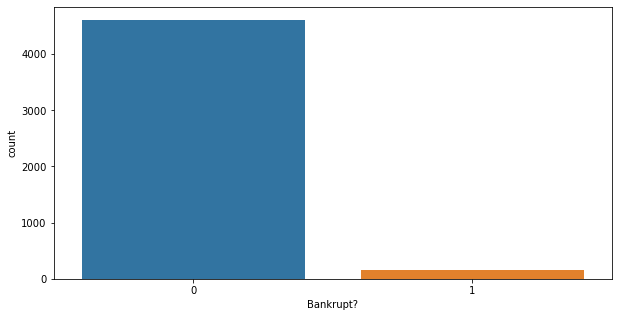

In [7]:
plt.figure(figsize = (10,5))
sns.countplot(y)
plt.show()

### Dane są niezbalansowane, więc wykorzystamy straified split

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X,
                                              y,
                                              test_size=0.3,
                                              stratify = y,
                                              random_state = 42)

## Wybór zmiennych do modelu

Do modelu wykorzystamy kolumny, które zostały wybrane w zadaniu domowym 3, czyli:
- `' ROA(C) before interest and depreciation before interest'`,
- `' ROA(A) before interest and % after tax'`,
- `' ROA(B) before interest and depreciation after tax'`,
- `' Operating Gross Margin'`,
- `' Tax rate (A)'`,
- `' Net Value Per Share (B)'`,
- `' Net Value Per Share (A)'`,
- `' Net Value Per Share (C)'`,
- `' Persistent EPS in the Last Four Seasons'`,
- `' Operating Profit Per Share (Yuan ¥)'`,
- `' Per Share Net profit before tax (Yuan ¥)'`,
- `' Debt ratio %'`,
- `' Net worth/Assets'`,
- `' Borrowing dependency'`,
- `' Operating profit/Paid-in capital'`,
- `' Net profit before tax/Paid-in capital'`,
- `' Working Capital to Total Assets'`,
- `' Cash/Total Assets'`,
- `' Current Liability to Assets'`,
- `' Working Capital/Equity'`,
- `' Current Liabilities/Equity'`,
- `' Retained Earnings to Total Assets'`,
- `' Total expense/Assets'`,
- `' Current Liability to Equity'`,
- `' Equity to Long-term Liability'`,
- `' CFO to Assets'`,
- `' Current Liability to Current Assets'`,
- `' Liability-Assets Flag'`,
- `' Net Income to Total Assets'`,
- `' Gross Profit to Sales'`,
- `' Net Income to Stockholder's Equity'`,
- `' Liability to Equity`.

In [9]:
cols = [' ROA(C) before interest and depreciation before interest',
       r' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Tax rate (A)', ' Net Value Per Share (B)',
       ' Net Value Per Share (A)', ' Net Value Per Share (C)',
       ' Persistent EPS in the Last Four Seasons',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Debt ratio %',
       ' Net worth/Assets', ' Borrowing dependency',
       ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital',
       ' Working Capital to Total Assets', ' Cash/Total Assets',
       ' Current Liability to Assets', ' Working Capital/Equity',
       ' Current Liabilities/Equity', ' Retained Earnings to Total Assets',
       ' Total expense/Assets', ' Current Liability to Equity',
       ' Equity to Long-term Liability', ' CFO to Assets',
       ' Current Liability to Current Assets', ' Liability-Assets Flag',
       ' Net Income to Total Assets', ' Gross Profit to Sales',
       ' Net Income to Stockholder\'s Equity', ' Liability to Equity']

In [10]:
train_X = train_X[cols]
test_X = test_X[cols]

## Skalowanie zmiennych

In [11]:
scaler = MinMaxScaler()

train_X = scaler.fit_transform(train_X)
train_X = pd.DataFrame(train_X, columns=cols)

test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns=cols)

## Funkcja pomocnicza do ewaluacji modeli

In [12]:
def statistics(y, y_pred, y_pred_proba):
    
    sns.set()

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # plot roc curve
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    axes[0].plot(fpr,tpr)
    axes[0].set_title('ROC curve')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    # plt.show()

    # plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(ax = axes[1], data = cm, annot=True, fmt=".0f", 
        xticklabels=['0 (Not bunkrupt)', '1 (bunkrupt)'], yticklabels=['0 (Not bunkrupt)', '1 (bunkrupt)'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion matrix')
    plt.show()

    # display metrics
    accuracy = accuracy_score(y, y_pred)
    balanced_accuracy = balanced_accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    roc_auc = auc(fpr, tpr)
    gini = (2 * roc_auc) - 1

    print(f'{accuracy=}')
    print(f'{balanced_accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')
    print(f'{gini=}')

## Decision tree

In [13]:
dt_clf = DecisionTreeClassifier(random_state=710, class_weight='balanced')

In [14]:
param_grid_dt = {
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_depth': [4, 8, 16, 32]
    }

Uważamy, że odpowiednią metryką do oceny modelu jest recall, gdyż false negativy są dla nas bardziej kosztowne od false positivów (chcemy unikać sytuacji, kiedy model przewidzi, że firma będzie dobrze prosperować, a w rzeczywistości zbankrutuje). Dobrą metryką jest również balanced_accuracy_score, ze względu na fakt, że dataset jest niezbalansowany.

In [15]:
dt_clf_grid = GridSearchCV(estimator=dt_clf, param_grid=param_grid_dt, cv=3, verbose=2, n_jobs=-1, scoring='recall')
dt_clf_grid.fit(train_X, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=710),
             n_jobs=-1,
             param_grid={'max_depth': [4, 8, 16, 32],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8]},
             scoring='recall', verbose=2)

In [16]:
dt_clf_grid.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

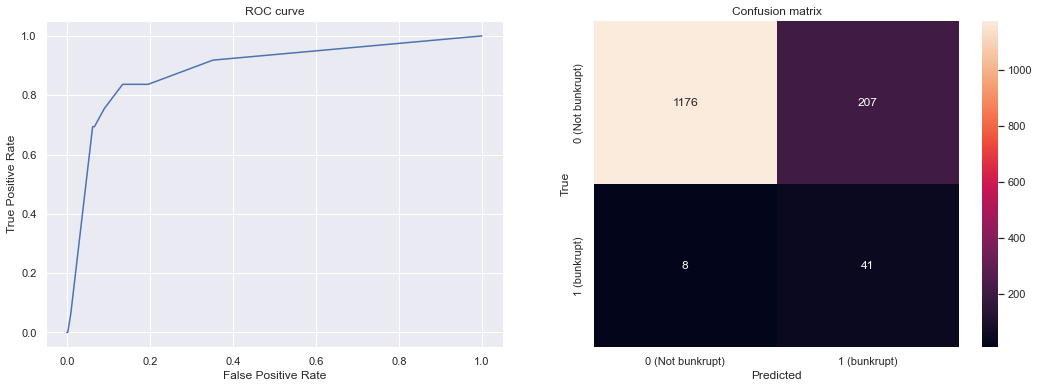

accuracy=0.8498603351955307
balanced_accuracy=0.8435300367435478
recall=0.8367346938775511
f1=0.2760942760942761
gini=0.7709209497247922


In [17]:
predicted_class = dt_clf_grid.predict(test_X)
predicted_prob = dt_clf_grid.predict_proba(test_X)
statistics(test_y, predicted_class, predicted_prob[:,1])

In [18]:
param_rand_dt = {
    'min_samples_split': [i for i in range(2,11)],
    'min_samples_leaf': [i for i in range(1,6)],
    'max_depth': [i for i in range(4,40)]
    }

In [19]:
dt_clf_rand = RandomizedSearchCV(estimator=dt_clf, param_distributions=param_rand_dt, n_iter=100, cv=3,
                               verbose=2, random_state=35, n_jobs=-1, scoring='recall')
dt_clf_rand.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=710),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 13, 14, 15, 16, 17,
                                                      18, 19, 20, 21, 22, 23,
                                                      24, 25, 26, 27, 28, 29,
                                                      30, 31, 32, 33, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10]},
                   random_state=35, scoring='recall', verbose=2)

In [20]:
dt_clf_rand.best_params_

{'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}

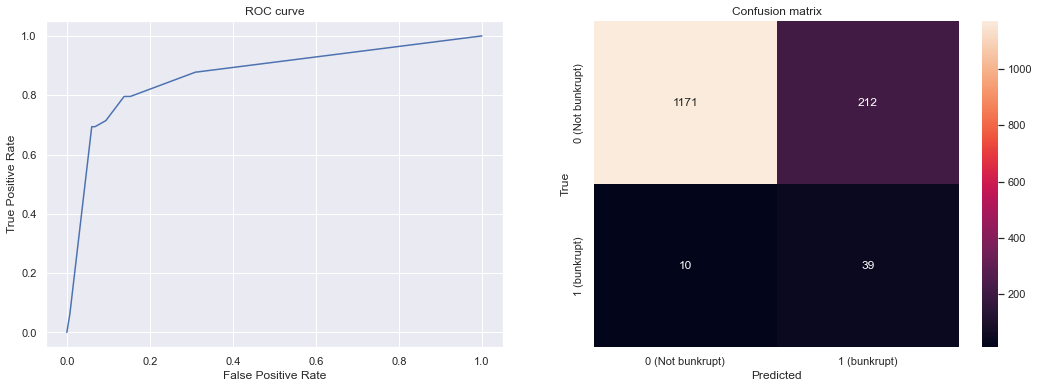

accuracy=0.8449720670391061
balanced_accuracy=0.8213142089807723
recall=0.7959183673469388
f1=0.26
gini=0.7366417282748239


In [21]:
predicted_class = dt_clf_rand.predict(test_X)
predicted_prob = dt_clf_rand.predict_proba(test_X)
statistics(test_y, predicted_class, predicted_prob[:,1])

## Random forest

In [22]:
rf_clf = RandomForestClassifier(random_state=710, class_weight='balanced')

In [23]:
param_grid_rf = {
    'n_estimators': [i for i in range(2, 31, 2)],
    'max_depth': [i for i in range(2, 31, 2)]
    }

In [24]:
rf_clf_grid = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=3, verbose=2, n_jobs=-1, scoring='recall')

rf_clf_grid.fit(train_X, train_y)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=710),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                       24, 26, 28, 30],
                         'n_estimators': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                          22, 24, 26, 28, 30]},
             scoring='recall', verbose=2)

In [25]:
rf_clf_grid.best_params_

{'max_depth': 2, 'n_estimators': 2}

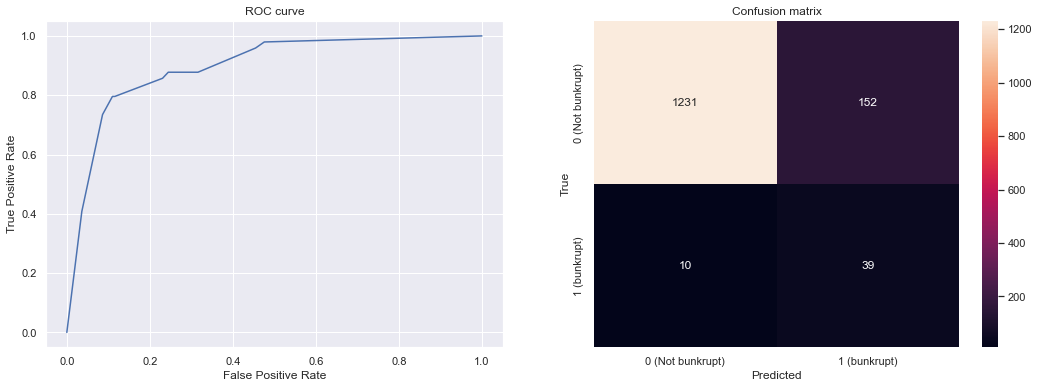

accuracy=0.8868715083798883
balanced_accuracy=0.8430061829504036
recall=0.7959183673469388
f1=0.32499999999999996
gini=0.7904142134077057


In [26]:
predicted_class = rf_clf_grid.predict(test_X)
predicted_prob = rf_clf_grid.predict_proba(test_X)
statistics(test_y, predicted_class, predicted_prob[:,1])

In [27]:
param_rand_rf = {
    'n_estimators': [i for i in range(2, 100)],
    'max_depth': [i for i in range(4, 31)]
    }

In [28]:
rf_clf_rand = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_rand_rf, n_iter=100, cv=3,
                               verbose=2, random_state=35, n_jobs=-1, scoring='recall')
rf_clf_rand.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=710),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 13, 14, 15, 16, 17,
                                                      18, 19, 20, 21, 22, 23,
                                                      24, 25, 26, 27, 28, 29,
                                                      30],
                                        'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19, 20, 21,
                                                         22, 23, 24, 25, 26, 27,
                                                         28, 29, 30, 31, ...]},
        

In [29]:
rf_clf_rand.best_params_

{'n_estimators': 69, 'max_depth': 4}

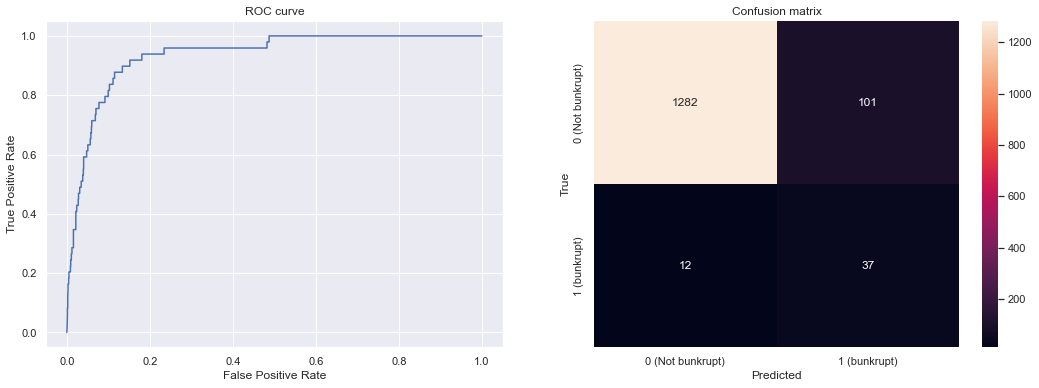

accuracy=0.9210893854748603
balanced_accuracy=0.8410361975592839
recall=0.7551020408163265
f1=0.39572192513368987
gini=0.8685495890330102


In [30]:
predicted_class = rf_clf_rand.predict(test_X)
predicted_prob = rf_clf_rand.predict_proba(test_X)
statistics(test_y, predicted_class, predicted_prob[:,1])

## SVM

In [31]:
svm_clf = SVC(probability=True, class_weight='balanced')

In [32]:
param_grid_svm = {
              'C': [0.1, 1, 10, 100, 1000],
              'gamma': [0.1, 0.01],
              'kernel': ['rbf', 'poly', 'sigmoid']
              }

In [40]:
svm_clf_grid = GridSearchCV(estimator=svm_clf, param_grid=param_grid_svm, cv=3, verbose=2, n_jobs=-1, scoring='recall')

svm_clf_grid.fit(train_X, train_y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=SVC(class_weight='balanced', probability=True),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.1, 0.01],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='recall', verbose=2)

In [41]:
svm_clf_grid.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

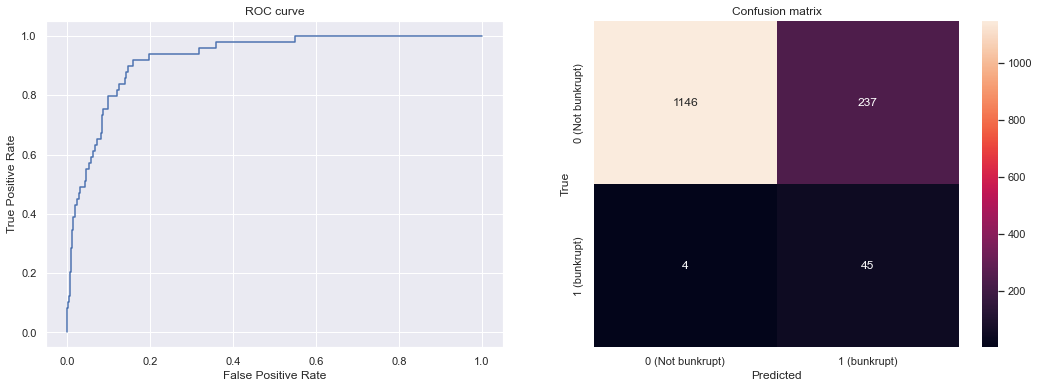

accuracy=0.8317039106145251
balanced_accuracy=0.8735003762893444
recall=0.9183673469387755
f1=0.27190332326283984
gini=0.8527306801245444


In [42]:
predicted_class = svm_clf_grid.predict(test_X)
predicted_prob = svm_clf_grid.predict_proba(test_X)
statistics(test_y, predicted_class, predicted_prob[:,1])

In [43]:
param_rand_svm = {
              'C': np.linspace(0.1, 1000, 10000),
              'gamma': np.linspace(0.0001, 1, 1000),
              'kernel': ['rbf', 'poly', 'sigmoid']
              }

In [44]:
svm_clf_rand = RandomizedSearchCV(estimator=svm_clf, param_distributions=param_rand_svm, n_iter=100, cv=3,
                               verbose=2, random_state=35, n_jobs=-1, scoring='recall')
svm_clf_rand.fit(train_X, train_y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=SVC(class_weight='balanced', probability=True),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
       1.000e+03]),
                                        'gamma': array([1.00000000e-04, 1.10090090e-03, 2.10180180e-03, 3.10270270e-03,
       4.10360360e-03, 5.10450450e-03, 6.10540541e-03, 7.10630631e-03,
       8.10720721e-03, 9...
       9.80982883e-01, 9.81983784e-01, 9.82984685e-01, 9.83985586e-01,
       9.84986486e-01, 9.85987387e-01, 9.86988288e-01, 9.87989189e-01,
       9.88990090e-01, 9.89990991e-01, 9.90991892e-01, 9.91992793e-01,
       9.92993694e-01, 9.93994595e-01, 9.94995495e-01, 9.95996396e-01,
       9.96997297e-01, 9.97998198e-01, 9.98999099e-01, 1.00000000e+00]),
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=35, scoring='recall', verbose=2)

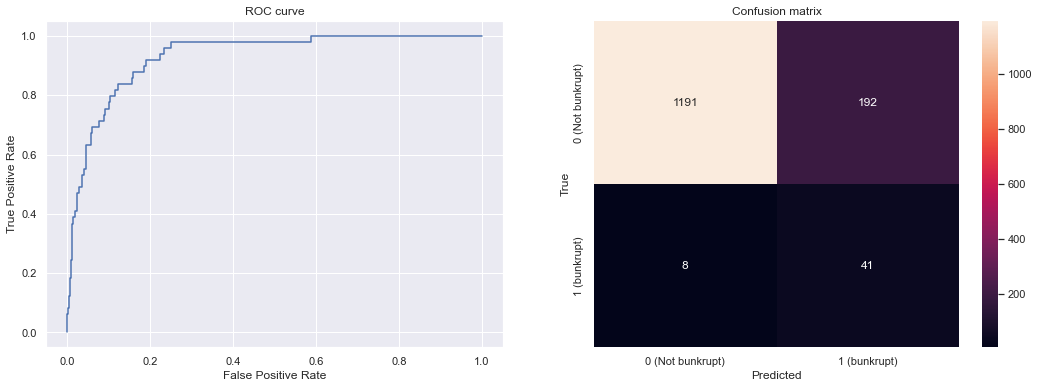

accuracy=0.8603351955307262
balanced_accuracy=0.8489530302359556
recall=0.8367346938775511
f1=0.29078014184397166
gini=0.8593710803193295


In [45]:
predicted_class = svm_clf_rand.predict(test_X)
predicted_prob = svm_clf_rand.predict_proba(test_X)
statistics(test_y, predicted_class, predicted_prob[:,1])

In [46]:
svm_clf_rand.best_params_

{'kernel': 'rbf', 'gamma': 0.014112612612612612, 'C': 327.7}

## Zespół walidujący  
### Hoang Laura i Bielecki Piotr

In [47]:
X = validation_df.drop(columns=['Bankrupt?'])
y = validation_df['Bankrupt?']

Czy dane są niezbalansowane tak jak w treningu?  
tak, są

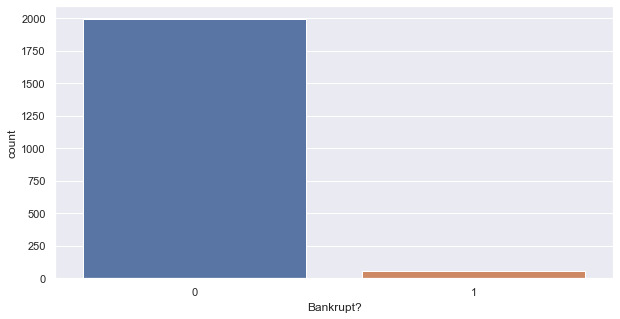

In [49]:
plt.figure(figsize = (10,5))
sns.countplot(y)
plt.show()

In [50]:
X = X[cols]

skalowanie, tak jak u grupy treningowej

In [52]:
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)

In [99]:
def statistics2(y, y_pred, y_pred_proba, y_val, y_val_pred, y_val_pred_proba):
    
    sns.set()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # plot roc curve
    fpr, tpr, _ = roc_curve(y,  y_pred_proba)
    axes[0].plot(fpr,tpr)
    fpr_val, tpr_val, _ = roc_curve(y_val,  y_val_pred_proba)
    axes[0].plot(fpr_val,tpr_val, color='red')
    axes[0].set_title('ROC curve (red for validation)')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
#     plt.show()
#     plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(ax = axes[1], data = cm, annot=True, fmt=".0f", 
        xticklabels=['0 (Not bunkrupt)', '1 (bunkrupt)'], yticklabels=['0 (Not bunkrupt)', '1 (bunkrupt)'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion matrix for test')
#     plt.show()
    
    cm = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(ax = axes[2], data = cm, annot=True, fmt=".0f", 
        xticklabels=['0 (Not bunkrupt)', '1 (bunkrupt)'], yticklabels=['0 (Not bunkrupt)', '1 (bunkrupt)'])
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')
    axes[2].set_title('Confusion matrix for validation')
#     plt.show()

    # display metrics
    accuracy = accuracy_score(y, y_pred)
    balanced_accuracy = balanced_accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = (2 * roc_auc) - 1
    
    accuracy_val = accuracy_score(y_val, y_val_pred)
    balanced_accuracy_val = balanced_accuracy_score(y_val, y_val_pred)
    recall_val = recall_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)
    roc_auc_val = auc(fpr_val, tpr_val)
    gini_val = (2 * roc_auc_val) - 1
    
    print(f'{accuracy=}')
    print(f'{balanced_accuracy=}')
    print(f'{recall=}')
    print(f'{f1=}')
    print(f'{gini=}\n')

    print(f'{accuracy_val=}')
    print(f'{balanced_accuracy_val=}')
    print(f'{recall_val=}')
    print(f'{f1_val=}')
    print(f'{gini_val=}')

## decision tree

u grupy treningowej optymalne parametry przy grid search to:

In [100]:
dt_clf_grid.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

##### test

accuracy=0.8498603351955307
balanced_accuracy=0.8435300367435478
recall=0.8367346938775511
f1=0.2760942760942761
gini=0.7709209497247922

accuracy_val=0.8313782991202346
balanced_accuracy_val=0.8005114860014357
recall_val=0.7678571428571429
f1_val=0.19953596287703015
gini_val=0.6433237616654701


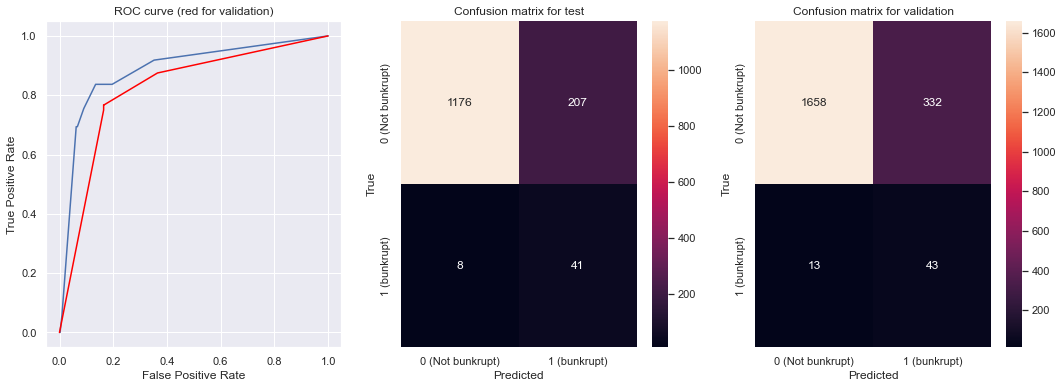

In [101]:
predicted_class = dt_clf_grid.predict(test_X)
predicted_prob = dt_clf_grid.predict_proba(test_X)
predicted_class_val = dt_clf_grid.predict(X)
predicted_prob_val = dt_clf_grid.predict_proba(X)
statistics2(test_y, predicted_class, predicted_prob[:,1], y, predicted_class_val, predicted_prob_val[:,1])

przy random search:

In [57]:
dt_clf_rand.best_params_

{'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 4}

accuracy=0.8449720670391061
balanced_accuracy=0.8213142089807723
recall=0.7959183673469388
f1=0.26
gini=0.7366417282748239

accuracy_val=0.8313782991202346
balanced_accuracy_val=0.8005114860014357
recall_val=0.7678571428571429
f1_val=0.19953596287703015
gini_val=0.6433237616654701


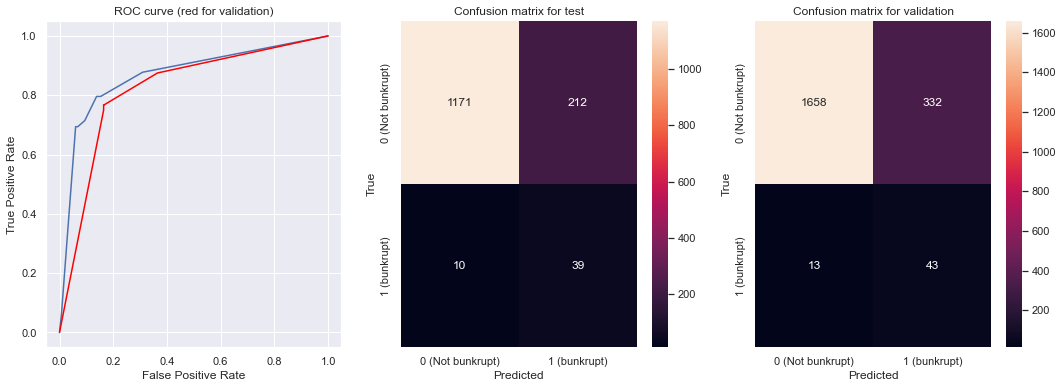

In [102]:
predicted_class = dt_clf_rand.predict(test_X)
predicted_prob = dt_clf_rand.predict_proba(test_X)
predicted_class_val = dt_clf_rand.predict(X)
predicted_prob_val = dt_clf_rand.predict_proba(X)
statistics2(test_y, predicted_class, predicted_prob[:,1], y, predicted_class_val, predicted_prob_val[:,1])

drzewo decyzyjne całkiem podobnie radzi sobie we wszystkich kategoriach, przy porównaniu testu i walidacji. oczywiście w każdej metryce wypadło gorzej w części walidacyjnej, zarówno przy grid search jak i random search - wyniki confusion matrix są bardzo podobne, przy walidacji mamy więcej nietrafionych klasyfikacji, na szczęście tylko w grupie false positive.

## Random Forest

In [64]:
rf_clf_grid.best_params_

{'max_depth': 2, 'n_estimators': 2}

accuracy=0.8868715083798883
balanced_accuracy=0.8430061829504036
recall=0.7959183673469388
f1=0.32499999999999996
gini=0.7904142134077057

accuracy_val=0.9340175953079178
balanced_accuracy_val=0.697083632447954
recall_val=0.44642857142857145
f1_val=0.27027027027027023
gini_val=0.631362167982771


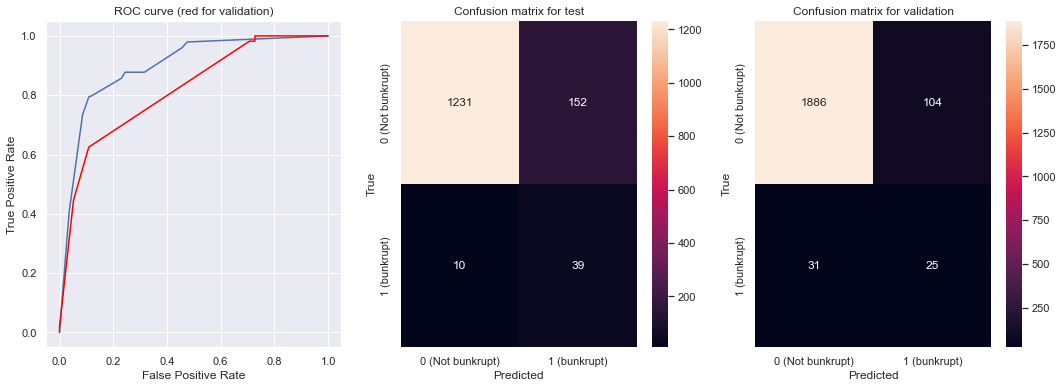

In [104]:
predicted_class = rf_clf_grid.predict(test_X)
predicted_prob = rf_clf_grid.predict_proba(test_X)
predicted_class_val = rf_clf_grid.predict(X)
predicted_prob_val = rf_clf_grid.predict_proba(X)
statistics2(test_y, predicted_class, predicted_prob[:,1], y, predicted_class_val, predicted_prob_val[:,1])

In [63]:
rf_clf_rand.best_params_

{'n_estimators': 69, 'max_depth': 4}

accuracy=0.9210893854748603
balanced_accuracy=0.8410361975592839
recall=0.7551020408163265
f1=0.39572192513368987
gini=0.8685495890330102

accuracy_val=0.9657869012707723
balanced_accuracy_val=0.661351399856425
recall_val=0.3392857142857143
f1_val=0.3518518518518519
gini_val=0.7697684852835607


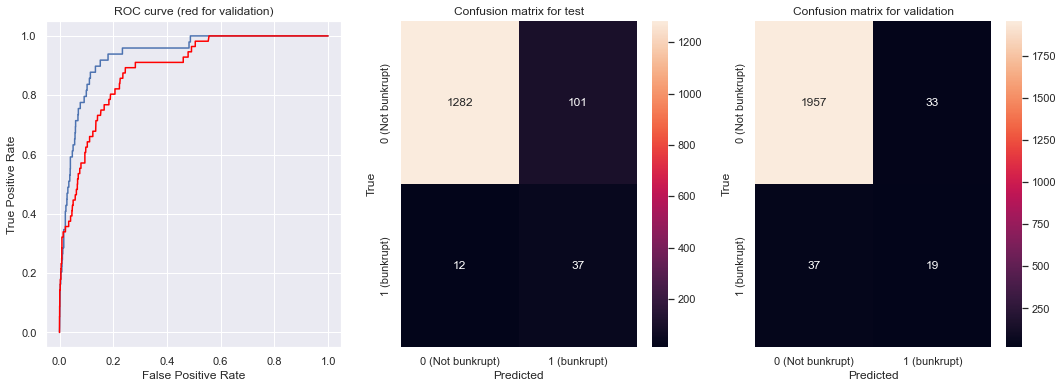

In [103]:
predicted_class = rf_clf_rand.predict(test_X)
predicted_prob = rf_clf_rand.predict_proba(test_X)
predicted_class_val = rf_clf_rand.predict(X)
predicted_prob_val = rf_clf_rand.predict_proba(X)
statistics2(test_y, predicted_class, predicted_prob[:,1], y, predicted_class_val, predicted_prob_val[:,1])

niestety, mimo lepszych wyników w `accuracy` dla ramki walidacyjnej, dla lasu losowego `recall` bardzo drastycznie spada przy porównaniu wyników tej metryki dla ramki testowej.  
Skoro najbardziej bolesne są dla nas false negative, model ten wydaje się być nieodpowiedni dla zadania.

## SVM

In [66]:
svm_clf_grid.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

accuracy=0.8317039106145251
balanced_accuracy=0.8735003762893444
recall=0.9183673469387755
f1=0.27190332326283984
gini=0.8527306801245444

accuracy_val=0.7043010752688172
balanced_accuracy_val=0.8393126346015793
recall_val=0.9821428571428571
f1_val=0.15384615384615385
gini_val=0.8753409906676237


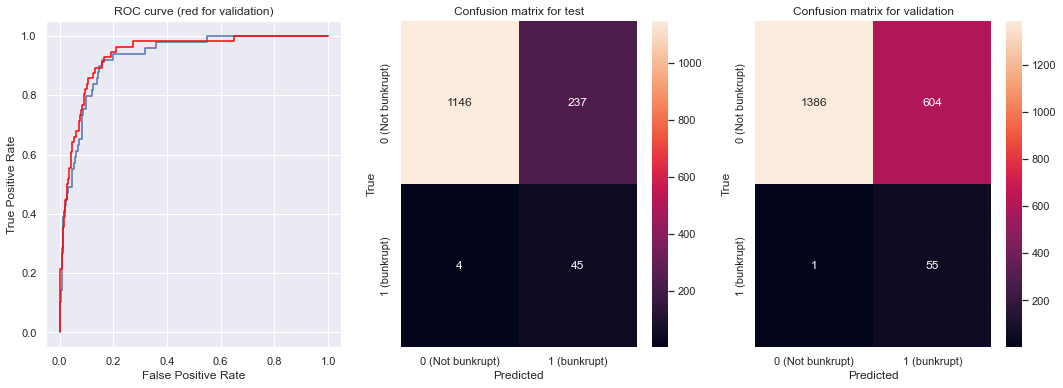

In [105]:
predicted_class = svm_clf_grid.predict(test_X)
predicted_prob = svm_clf_grid.predict_proba(test_X)
predicted_class_val = svm_clf_grid.predict(X)
predicted_prob_val = svm_clf_grid.predict_proba(X)
statistics2(test_y, predicted_class, predicted_prob[:,1], y, predicted_class_val, predicted_prob_val[:,1])

In [106]:
svm_clf_rand.best_params_

{'kernel': 'rbf', 'gamma': 0.014112612612612612, 'C': 327.7}

accuracy=0.8603351955307262
balanced_accuracy=0.8489530302359556
recall=0.8367346938775511
f1=0.29078014184397166
gini=0.8593710803193295

accuracy_val=0.11534701857282502
balanced_accuracy_val=0.5452261306532663
recall_val=1.0
f1_val=0.05827263267429761
gini_val=0.8835786073223257


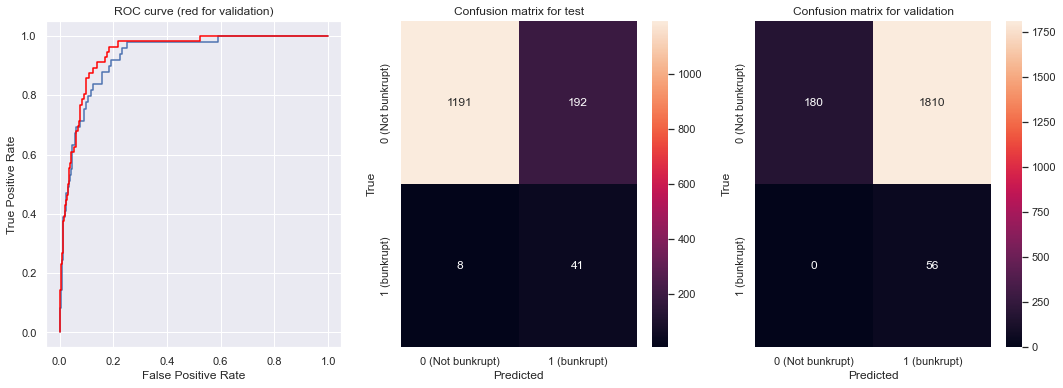

In [107]:
predicted_class = svm_clf_rand.predict(test_X)
predicted_prob = svm_clf_rand.predict_proba(test_X)
predicted_class_val = svm_clf_rand.predict(X)
predicted_prob_val = svm_clf_rand.predict_proba(X)
statistics2(test_y, predicted_class, predicted_prob[:,1], y, predicted_class_val, predicted_prob_val[:,1])

W przypadku grid search, model ma wybitny `recall`, natomiast niestety około 1/3 rekordów została błędnie przyporządkowana jako bankruci, mimo, że takimi nie są. Udało nam się ominąć false negatives, niestety kosztem znacznie większej liczby false positives.  
W przypadku random search model jest jeszcze gorszy, choć `recall` ma równy 1 - super. Szkoda tylko, że tak jak w przypadku grid search - kosztem false positives. Nie opłacałoby się bazować na takim modelu.

Grid search wydaje się być zazwyczaj lepszą opcją, jeśli chodzi o hiperparametryzację modelu.